# MNIST Conditional Variational Autoencoder (CVAE)

This notebook implements a Conditional VAE specifically designed for MNIST dataset.
The model can generate handwritten digits conditioned on class labels (0-9), allowing for controlled generation.

## Key Features:
- **CNN Encoder**: Convolutional layers optimized for 28x28 grayscale images
- **Conditional Architecture**: Class conditioning throughout the network
- **CNN Decoder**: Transposed convolutions for image reconstruction
- **β-VAE Support**: Controllable disentanglement
- **MNIST Optimized**: Architecture specifically tuned for handwritten digits

## Imports and Setup

In [ ]:
!pip install -U huggingface_hub datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.32.4
    Uninstalling huggingface-hub-0.32.4:
      Successfully uninstalled huggingface-hub-0.32.4
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
import math
from tqdm import tqdm
from typing import List

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## Data Loading and Preprocessing

In [ ]:
# Load MNIST dataset
dataset = load_dataset("mnist")
print(f"Dataset info: {dataset}")

# MNIST class names (digits 0-9)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(class_names)

# Define transforms for MNIST (28x28 grayscale images)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = MNISTDataset(dataset['train'], transform=transform)
test_dataset = MNISTDataset(dataset['test'], transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of classes: {num_classes}")

README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset info: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
Train samples: 60000
Test samples: 10000
Batch size: 128
Number of classes: 10


## Data Visualization

Batch shape: torch.Size([128, 1, 28, 28])
Labels shape: torch.Size([128])


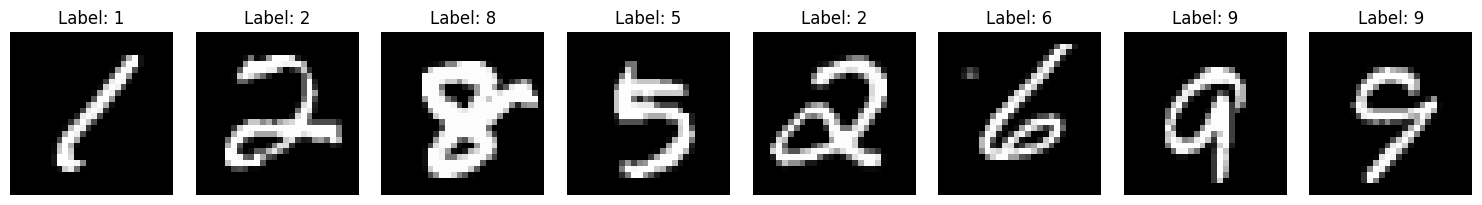

In [ ]:
# Visualize some samples
def visualize_samples(data_loader, num_samples=8):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

    # Plot samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
    for i in range(num_samples):
        # Convert from [-1, 1] to [0, 1] for visualization
        img = (images[i].squeeze() + 1) / 2
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(train_loader)

## Model Architecture

In [ ]:
class MNISTEncoder(nn.Module):
    """CNN-based encoder for MNIST CVAE"""
    def __init__(self, input_channels=1, latent_dim=64, num_classes=10):
        super(MNISTEncoder, self).__init__()

        self.input_channels = input_channels
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Class embedding
        self.class_embedding = nn.Embedding(num_classes, 32)

        # Convolutional layers
        # Input: 28x28x1 -> 14x14x32
        self.conv1 = nn.Conv2d(input_channels + 1, 32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # 14x14x32 -> 7x7x64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # 7x7x64 -> 4x4x128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Flatten: 4x4x128 = 2048
        self.fc_input_dim = 4 * 4 * 128

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_dim + 32, 512)  # +32 for class embedding
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x, class_label):
        batch_size = x.size(0)

        # Get class embedding and expand to image dimensions
        class_emb = self.class_embedding(class_label)  # [batch, 32]
        # Create a single-channel class map with constant values
        class_map = torch.ones(batch_size, 1, 28, 28, device=x.device) * class_label.float().view(batch_size, 1, 1, 1)

        # Concatenate input with class information
        x = torch.cat([x, class_map], dim=1)  # [batch, 2, 28, 28]

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten
        x = x.view(batch_size, -1)

        # Concatenate with class embedding
        x = torch.cat([x, class_emb], dim=1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

In [ ]:
class MNISTDecoder(nn.Module):
    """CNN-based decoder for MNIST CVAE"""
    def __init__(self, latent_dim=64, output_channels=1, num_classes=10):
        super(MNISTDecoder, self).__init__()

        self.latent_dim = latent_dim
        self.output_channels = output_channels
        self.num_classes = num_classes

        # Class embedding
        self.class_embedding = nn.Embedding(num_classes, 32)

        # Project latent + class to feature map
        self.fc1 = nn.Linear(latent_dim + 32, 512)
        self.fc2 = nn.Linear(512, 4 * 4 * 128)  # 4x4x128

        # Transposed convolutional layers
        # 4x4x128 -> 7x7x64
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # 7x7x64 -> 14x14x32
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # 14x14x32 -> 28x28x1
        self.deconv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)

        self.dropout = nn.Dropout(0.2)

    def forward(self, z, class_label):
        batch_size = z.size(0)

        # Get class embedding
        class_emb = self.class_embedding(class_label)  # [batch, 32]

        # Concatenate latent code with class embedding
        z = torch.cat([z, class_emb], dim=1)  # [batch, latent_dim + 32]

        # Fully connected layers
        x = F.relu(self.fc1(z))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        # Reshape to feature map
        x = x.view(batch_size, 128, 4, 4)

        # Transposed convolutional layers
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = torch.tanh(self.deconv3(x))  # Output in [-1, 1]

        return x

In [ ]:
class MNISTCVAE(nn.Module):
    """Complete MNIST Conditional VAE"""
    def __init__(self, input_channels=1, latent_dim=64, num_classes=10):
        super(MNISTCVAE, self).__init__()

        self.input_channels = input_channels
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder and Decoder
        self.encoder = MNISTEncoder(input_channels, latent_dim, num_classes)
        self.decoder = MNISTDecoder(latent_dim, input_channels, num_classes)

    def encode(self, x, class_label):
        """Encode input to latent parameters"""
        return self.encoder(x, class_label)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, class_label):
        """Decode latent code to image"""
        return self.decoder(z, class_label)

    def forward(self, x, class_label):
        """Forward pass through the entire model"""
        mu, logvar = self.encode(x, class_label)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, class_label)
        return recon_x, mu, logvar

    def sample(self, num_samples, class_label, device):
        """Generate samples from the model"""
        with torch.no_grad():
            # Sample from standard normal
            z = torch.randn(num_samples, self.latent_dim).to(device)

            # Ensure class_label is the right shape
            if isinstance(class_label, int):
                class_label = torch.tensor([class_label] * num_samples).to(device)
            elif len(class_label) == 1:
                class_label = class_label.repeat(num_samples)

            # Decode
            samples = self.decode(z, class_label)
            return samples

## Loss Function

In [ ]:
def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    CVAE loss function combining reconstruction loss and KL divergence

    Args:
        recon_x: Reconstructed images
        x: Original images
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: β-VAE parameter for controlling disentanglement

    Returns:
        total_loss, reconstruction_loss, kl_loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    # KL(q(z|x,c) || p(z)) where p(z) = N(0,I)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

## Training Setup

In [ ]:
# Model hyperparameters
latent_dim = 64
learning_rate = 1e-3
num_epochs = 20
beta = 1.0  # β-VAE parameter

# Initialize model
model = MNISTCVAE(input_channels=1, latent_dim=latent_dim, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Configuration:")
print(f"  Latent Dimension: {latent_dim}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")
print(f"  Beta (β-VAE): {beta}")
print(f"  Total Parameters: {total_params:,}")
print(f"  Trainable Parameters: {trainable_params:,}")
print(f"  Device: {device}")

Model Configuration:
  Latent Dimension: 64
  Learning Rate: 0.001
  Epochs: 20
  Beta (β-VAE): 1.0
  Total Parameters: 2,447,553
  Trainable Parameters: 2,447,553
  Device: cuda


## Training Loop

In [ ]:
def train_epoch(model, train_loader, optimizer, beta=1.0):
    """Train CVAE for one epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    num_batches = len(train_loader)

    for batch_idx, (data, labels) in enumerate(tqdm(train_loader, desc="Training")):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data, labels)

        # Compute loss
        loss, recon_loss, kl_loss = cvae_loss(recon_batch, data, mu, logvar, beta)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    # Average losses
    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

def evaluate(model, test_loader, beta=1.0):
    """Evaluate CVAE on test set"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            # Forward pass
            recon_batch, mu, logvar = model(data, labels)

            # Compute loss
            loss, recon_loss, kl_loss = cvae_loss(recon_batch, data, mu, logvar, beta)

            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

    # Average losses
    avg_loss = total_loss / len(test_loader.dataset)
    avg_recon_loss = total_recon_loss / len(test_loader.dataset)
    avg_kl_loss = total_kl_loss / len(test_loader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

In [ ]:
# Training history
train_losses = []
train_recon_losses = []
train_kl_losses = []
test_losses = []
test_recon_losses = []
test_kl_losses = []

print("Starting training...")
print("=" * 50)

for epoch in range(num_epochs):
    # Train
    train_loss, train_recon, train_kl = train_epoch(model, train_loader, optimizer, beta)

    # Evaluate
    test_loss, test_recon, test_kl = evaluate(model, test_loader, beta)

    # Store losses
    train_losses.append(train_loss)
    train_recon_losses.append(train_recon)
    train_kl_losses.append(train_kl)
    test_losses.append(test_loss)
    test_recon_losses.append(test_recon)
    test_kl_losses.append(test_kl)

    # Print progress
    print(f"Epoch {epoch+1:2d}/{num_epochs}:")
    print(f"  Train - Total: {train_loss:.4f}, Recon: {train_recon:.4f}, KL: {train_kl:.4f}")
    print(f"  Test  - Total: {test_loss:.4f}, Recon: {test_recon:.4f}, KL: {test_kl:.4f}")
    print("-" * 50)

print("Training completed!")

Starting training...


Training: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]


Epoch  1/20:
  Train - Total: 170.2838, Recon: 162.2125, KL: 8.0713
  Test  - Total: 107.9804, Recon: 97.4188, KL: 10.5616
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]


Epoch  2/20:
  Train - Total: 108.5025, Recon: 97.2605, KL: 11.2419
  Test  - Total: 89.8947, Recon: 79.4966, KL: 10.3982
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]


Epoch  3/20:
  Train - Total: 98.7302, Recon: 87.5002, KL: 11.2301
  Test  - Total: 83.9114, Recon: 73.0237, KL: 10.8877
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]


Epoch  4/20:
  Train - Total: 94.6852, Recon: 83.3243, KL: 11.3609
  Test  - Total: 80.1736, Recon: 68.8992, KL: 11.2744
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]


Epoch  5/20:
  Train - Total: 92.0381, Recon: 80.5684, KL: 11.4697
  Test  - Total: 78.5370, Recon: 67.4962, KL: 11.0407
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]


Epoch  6/20:
  Train - Total: 90.2860, Recon: 78.7210, KL: 11.5650
  Test  - Total: 77.5856, Recon: 66.2627, KL: 11.3229
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]


Epoch  7/20:
  Train - Total: 88.4307, Recon: 76.7911, KL: 11.6396
  Test  - Total: 75.6733, Recon: 64.6158, KL: 11.0575
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]


Epoch  8/20:
  Train - Total: 87.1902, Recon: 75.5596, KL: 11.6306
  Test  - Total: 75.2498, Recon: 63.7389, KL: 11.5109
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]


Epoch  9/20:
  Train - Total: 86.4249, Recon: 74.7342, KL: 11.6907
  Test  - Total: 74.9313, Recon: 63.8627, KL: 11.0685
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]


Epoch 10/20:
  Train - Total: 85.2860, Recon: 73.5335, KL: 11.7524
  Test  - Total: 73.8112, Recon: 62.3848, KL: 11.4264
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]


Epoch 11/20:
  Train - Total: 84.1562, Recon: 72.3736, KL: 11.7826
  Test  - Total: 73.1055, Recon: 61.6620, KL: 11.4435
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]


Epoch 12/20:
  Train - Total: 83.2568, Recon: 71.4006, KL: 11.8562
  Test  - Total: 73.0182, Recon: 61.9695, KL: 11.0487
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]


Epoch 13/20:
  Train - Total: 82.2742, Recon: 70.4132, KL: 11.8610
  Test  - Total: 71.7930, Recon: 60.3911, KL: 11.4019
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]


Epoch 14/20:
  Train - Total: 81.4361, Recon: 69.5093, KL: 11.9268
  Test  - Total: 71.3119, Recon: 59.8391, KL: 11.4728
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]


Epoch 15/20:
  Train - Total: 80.5944, Recon: 68.6346, KL: 11.9598
  Test  - Total: 71.2773, Recon: 59.5659, KL: 11.7114
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]


Epoch 16/20:
  Train - Total: 79.8295, Recon: 67.8149, KL: 12.0146
  Test  - Total: 70.8947, Recon: 59.3622, KL: 11.5325
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]


Epoch 17/20:
  Train - Total: 79.1293, Recon: 67.0953, KL: 12.0340
  Test  - Total: 70.2348, Recon: 58.4627, KL: 11.7721
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]


Epoch 18/20:
  Train - Total: 78.3853, Recon: 66.2783, KL: 12.1070
  Test  - Total: 69.7266, Recon: 57.8606, KL: 11.8660
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]


Epoch 19/20:
  Train - Total: 77.8516, Recon: 65.7423, KL: 12.1093
  Test  - Total: 69.6691, Recon: 57.6952, KL: 11.9739
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]


Epoch 20/20:
  Train - Total: 77.1125, Recon: 64.9719, KL: 12.1406
  Test  - Total: 69.1749, Recon: 57.4051, KL: 11.7697
--------------------------------------------------
Training completed!


## Results Visualization

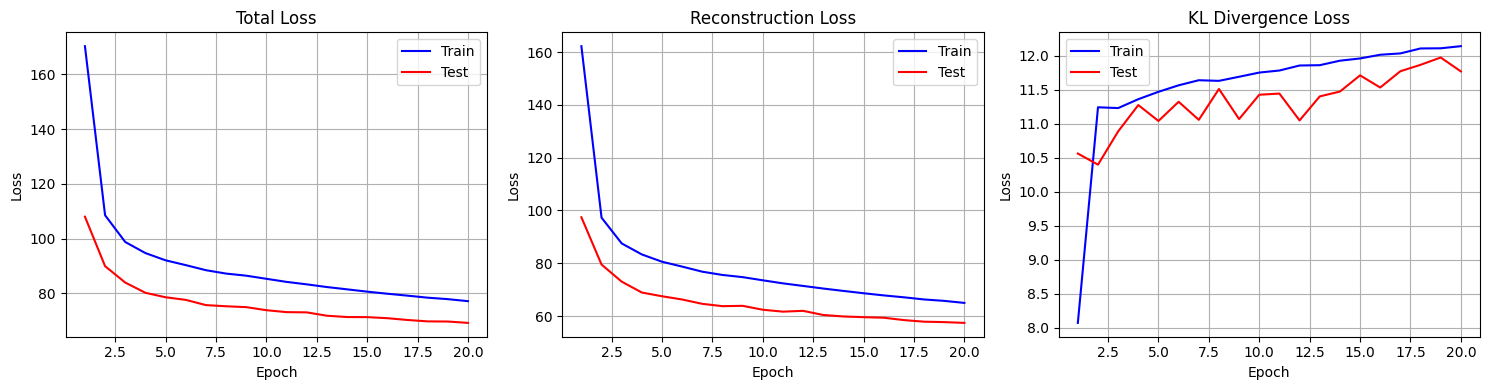

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = range(1, num_epochs + 1)

# Total loss
axes[0].plot(epochs, train_losses, 'b-', label='Train')
axes[0].plot(epochs, test_losses, 'r-', label='Test')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Reconstruction loss
axes[1].plot(epochs, train_recon_losses, 'b-', label='Train')
axes[1].plot(epochs, test_recon_losses, 'r-', label='Test')
axes[1].set_title('Reconstruction Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# KL loss
axes[2].plot(epochs, train_kl_losses, 'b-', label='Train')
axes[2].plot(epochs, test_kl_losses, 'r-', label='Test')
axes[2].set_title('KL Divergence Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Reconstruction Examples

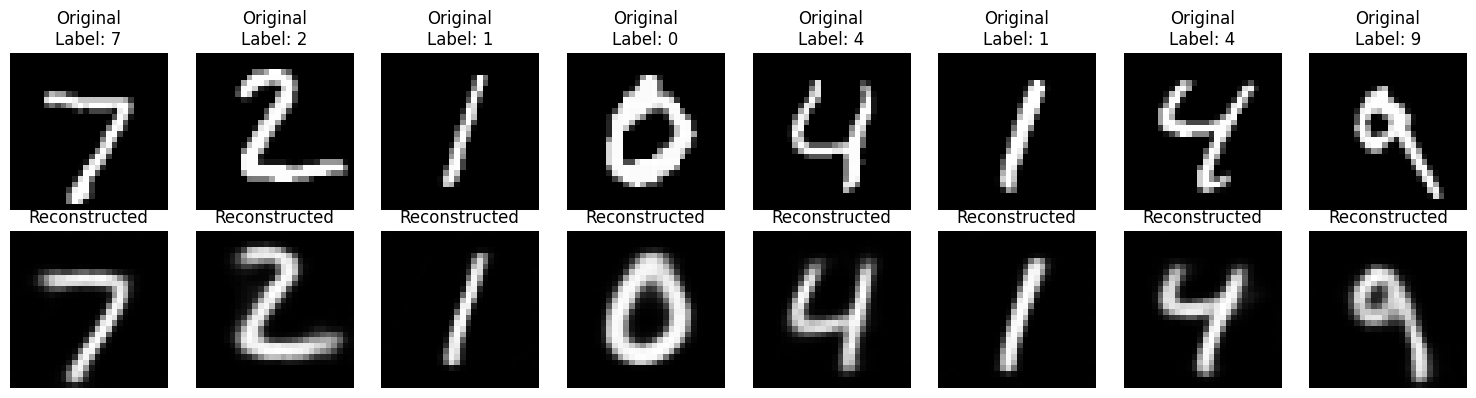

In [ ]:
def show_reconstructions(model, test_loader, num_examples=8):
    """Show original vs reconstructed images"""
    model.eval()

    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        data, labels = next(data_iter)
        data = data[:num_examples].to(device)
        labels = labels[:num_examples].to(device)

        # Reconstruct
        recon_data, _, _ = model(data, labels)

        # Convert to numpy for plotting
        data = data.cpu()
        recon_data = recon_data.cpu()
        labels = labels.cpu()

        # Plot
        fig, axes = plt.subplots(2, num_examples, figsize=(15, 4))

        for i in range(num_examples):
            # Original
            orig_img = (data[i].squeeze() + 1) / 2  # Convert from [-1,1] to [0,1]
            axes[0, i].imshow(orig_img, cmap='gray')
            axes[0, i].set_title(f'Original\nLabel: {labels[i].item()}')
            axes[0, i].axis('off')

            # Reconstruction
            recon_img = (recon_data[i].squeeze() + 1) / 2  # Convert from [-1,1] to [0,1]
            axes[1, i].imshow(recon_img, cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

show_reconstructions(model, test_loader)

## Conditional Generation

Generated samples for each digit class:

Digit 0:


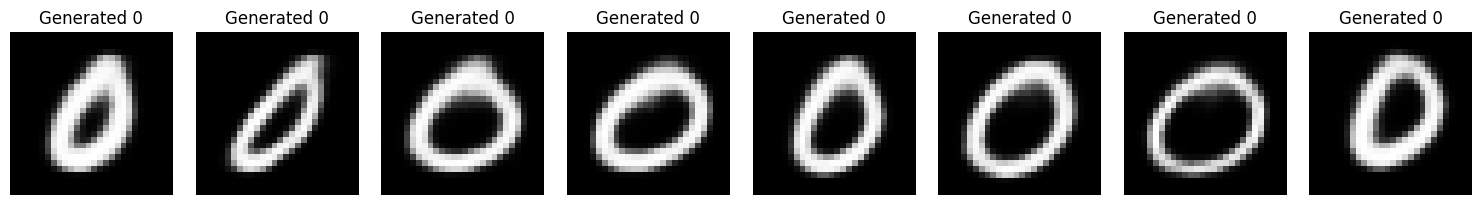


Digit 1:


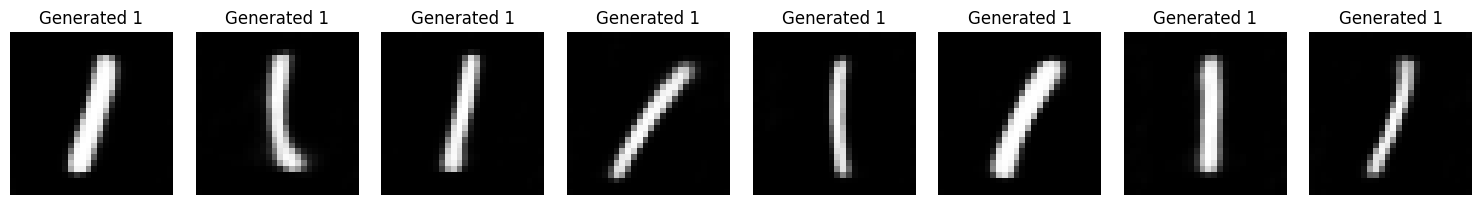


Digit 2:


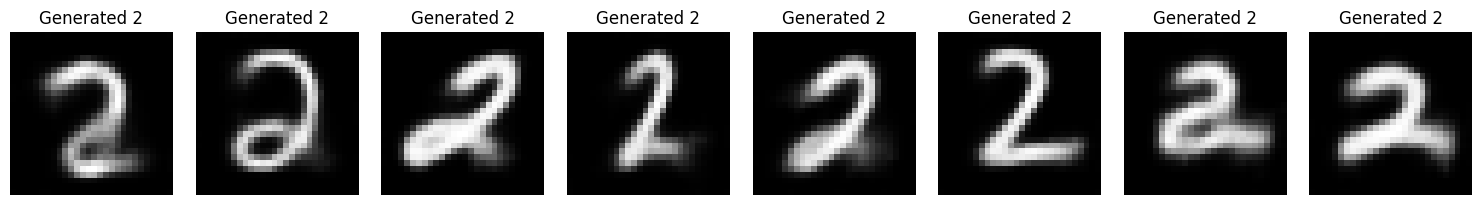


Digit 3:


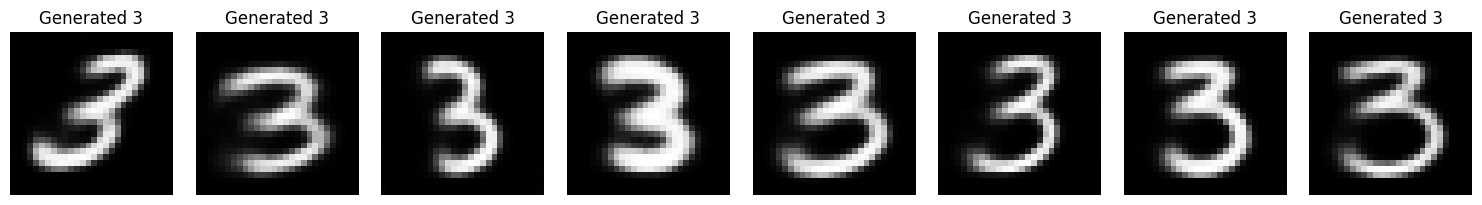


Digit 4:


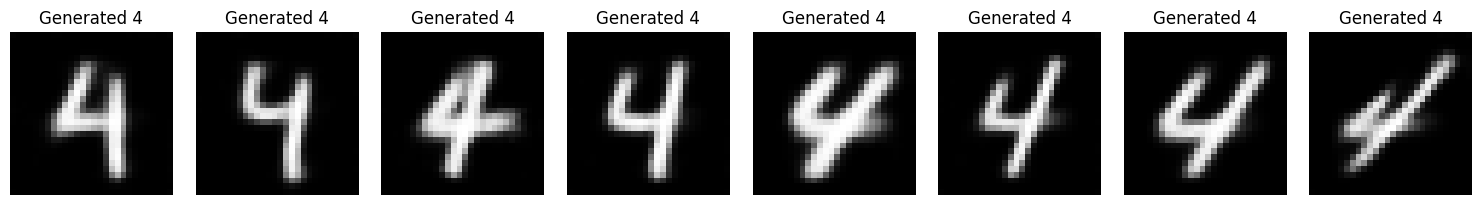


Digit 5:


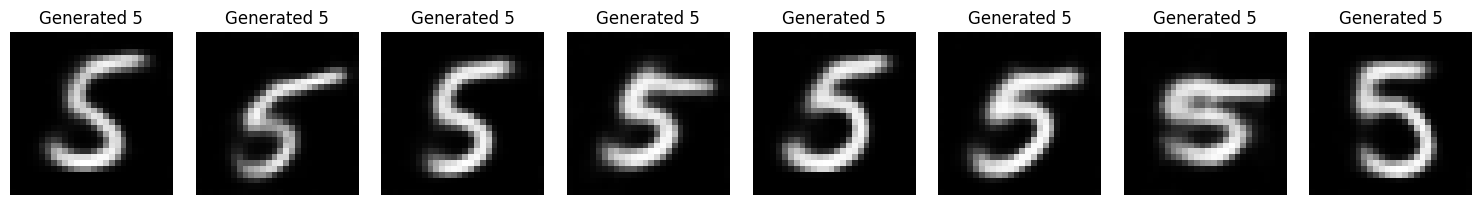


Digit 6:


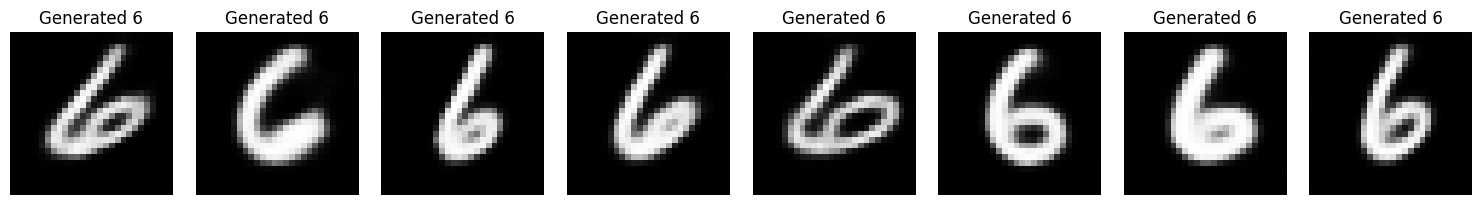


Digit 7:


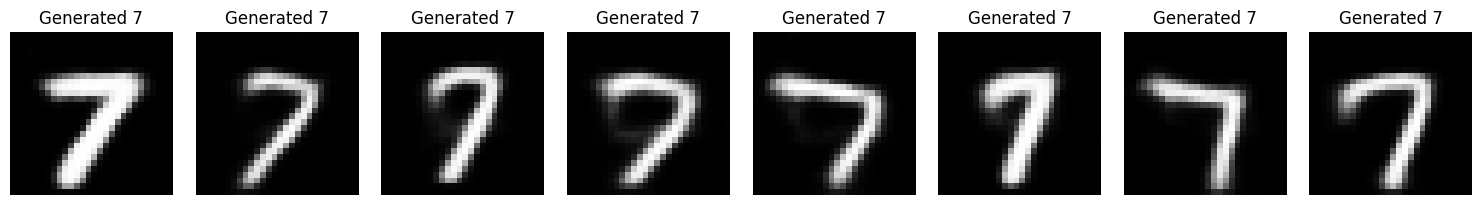


Digit 8:


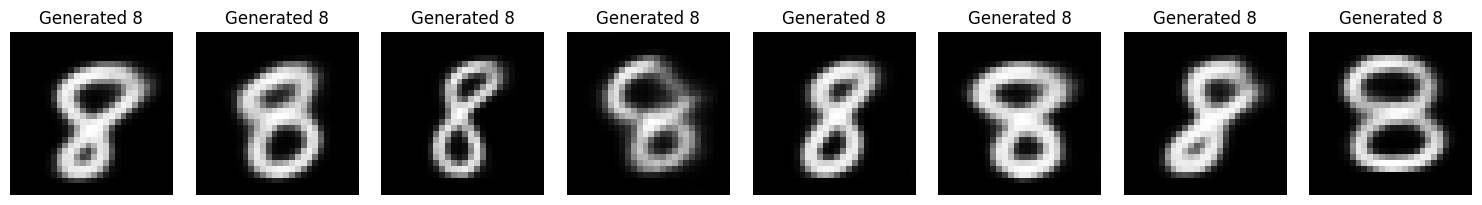


Digit 9:


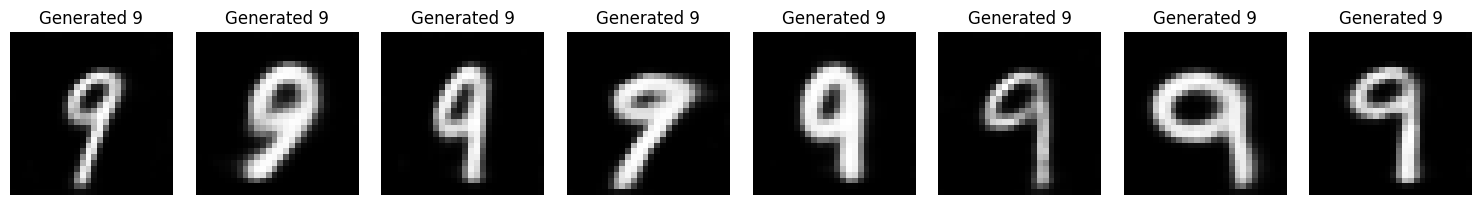

In [ ]:
def generate_class_samples(model, class_label, num_samples=8):
    """Generate samples for a specific class"""
    model.eval()

    # Generate samples
    samples = model.sample(num_samples, class_label, device)
    samples = samples.cpu()

    # Plot
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))

    for i in range(num_samples):
        img = (samples[i].squeeze() + 1) / 2  # Convert from [-1,1] to [0,1]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Generated {class_label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Generate samples for each digit
print("Generated samples for each digit class:")
for digit in range(10):
    print(f"\nDigit {digit}:")
    generate_class_samples(model, digit, num_samples=8)

Comprehensive generation grid:


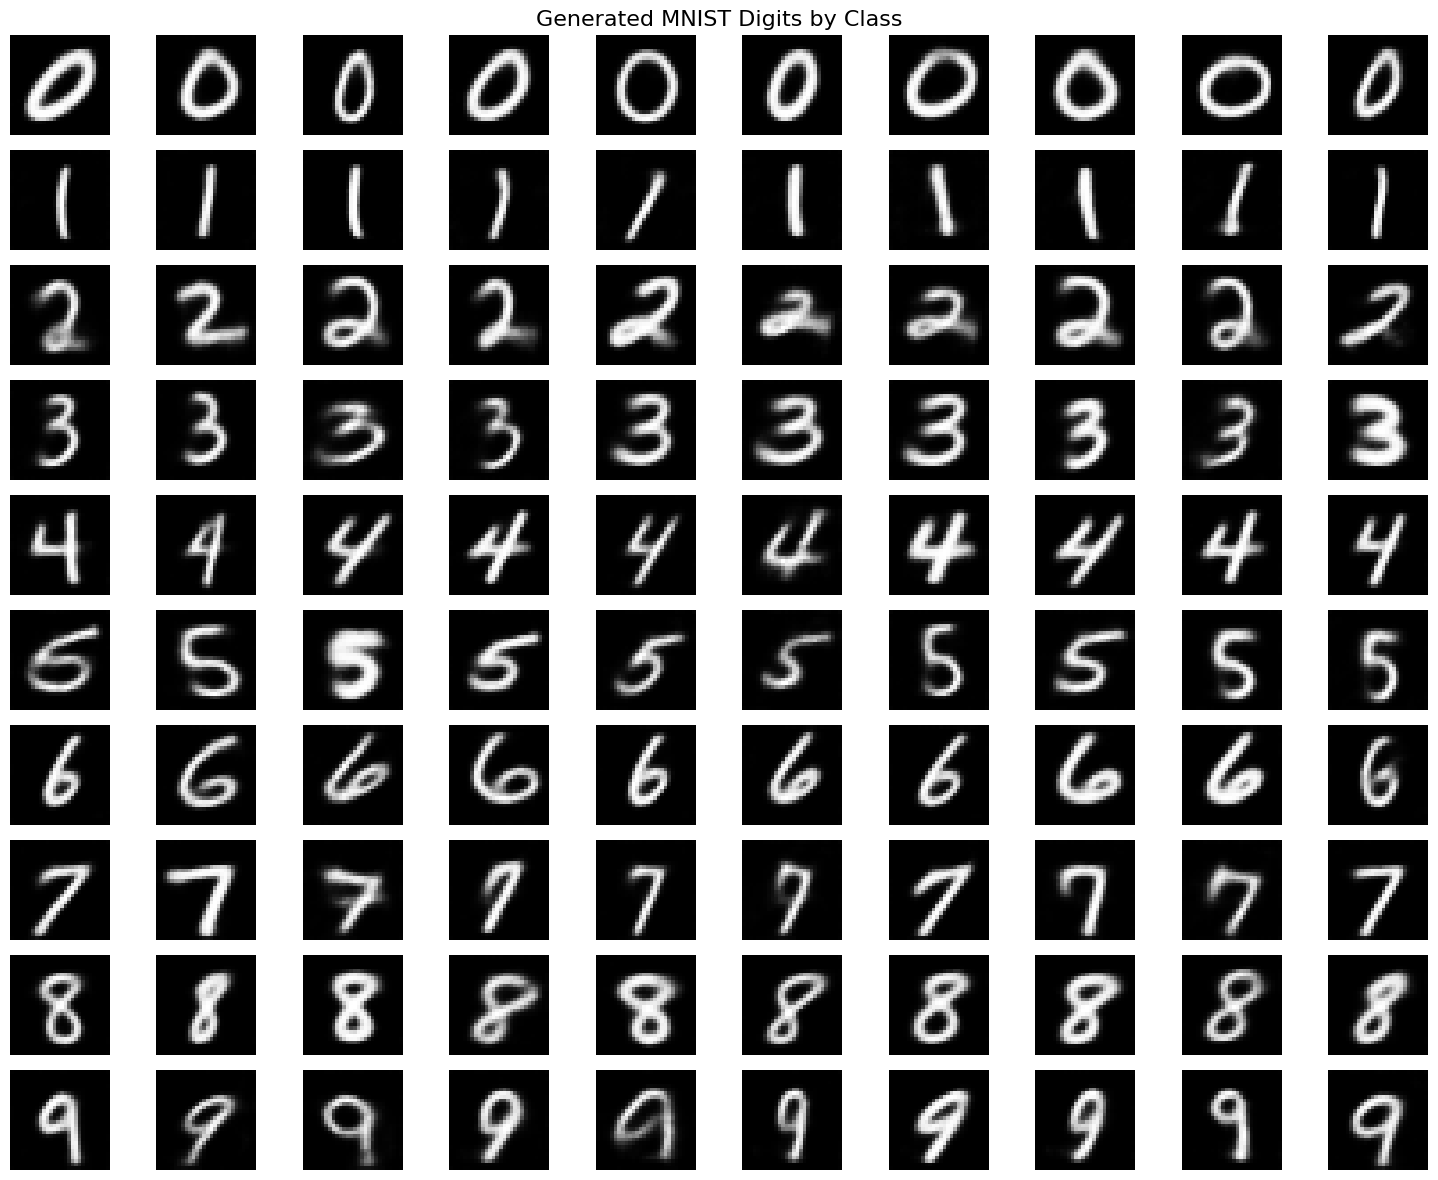

In [ ]:
def generate_digit_grid(model, samples_per_class=10):
    """Generate a grid showing samples from all digit classes"""
    model.eval()

    fig, axes = plt.subplots(10, samples_per_class, figsize=(15, 12))

    for digit in range(10):
        # Generate samples for this digit
        samples = model.sample(samples_per_class, digit, device)
        samples = samples.cpu()

        for i in range(samples_per_class):
            img = (samples[i].squeeze() + 1) / 2  # Convert from [-1,1] to [0,1]
            axes[digit, i].imshow(img, cmap='gray')
            axes[digit, i].axis('off')

            # Add digit label on the left
            if i == 0:
                axes[digit, i].set_ylabel(f'Digit {digit}', fontsize=12, rotation=0, labelpad=20)

    plt.suptitle('Generated MNIST Digits by Class', fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate comprehensive grid
print("Comprehensive generation grid:")
generate_digit_grid(model, samples_per_class=10)

## Latent Space Exploration

Latent space interpolation examples:


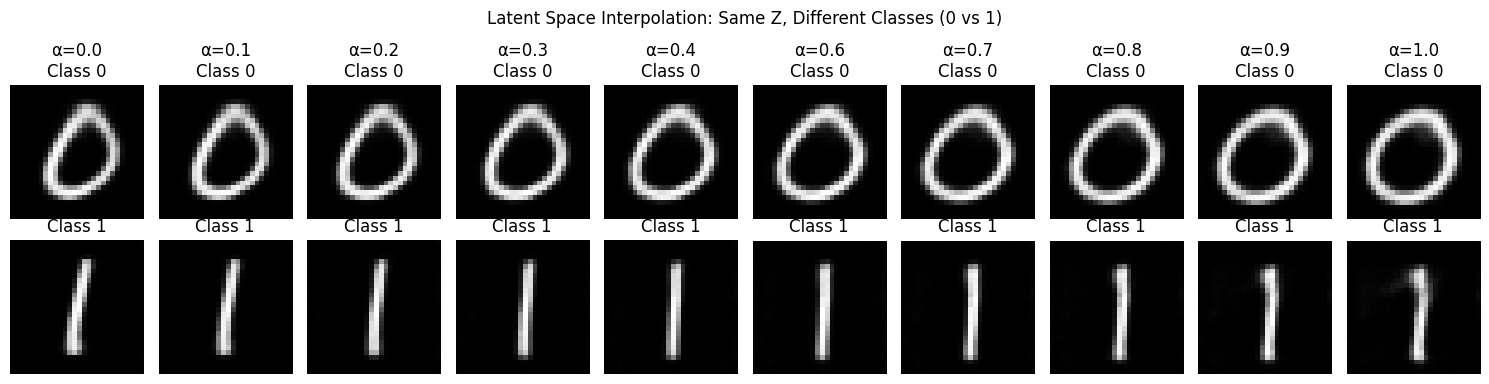

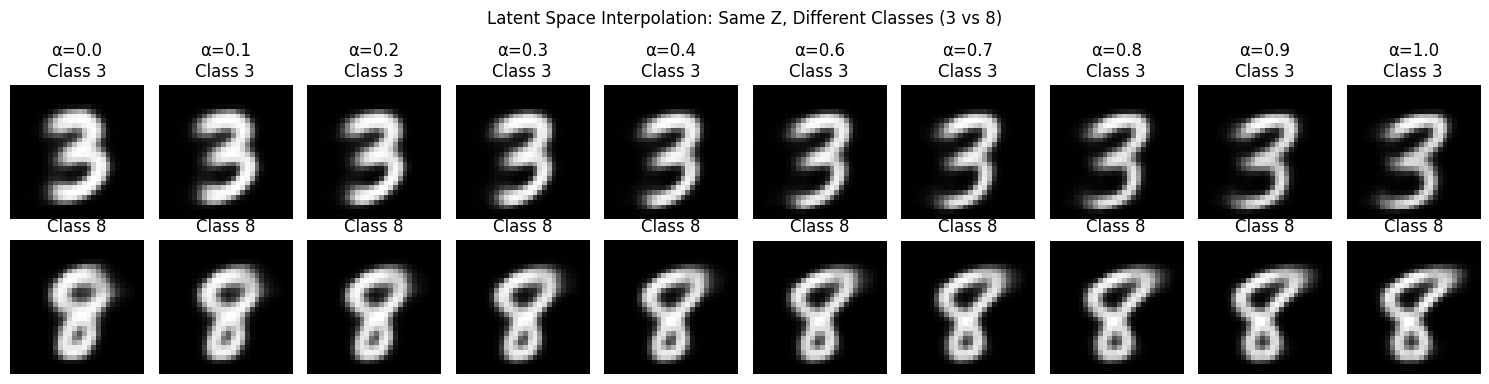

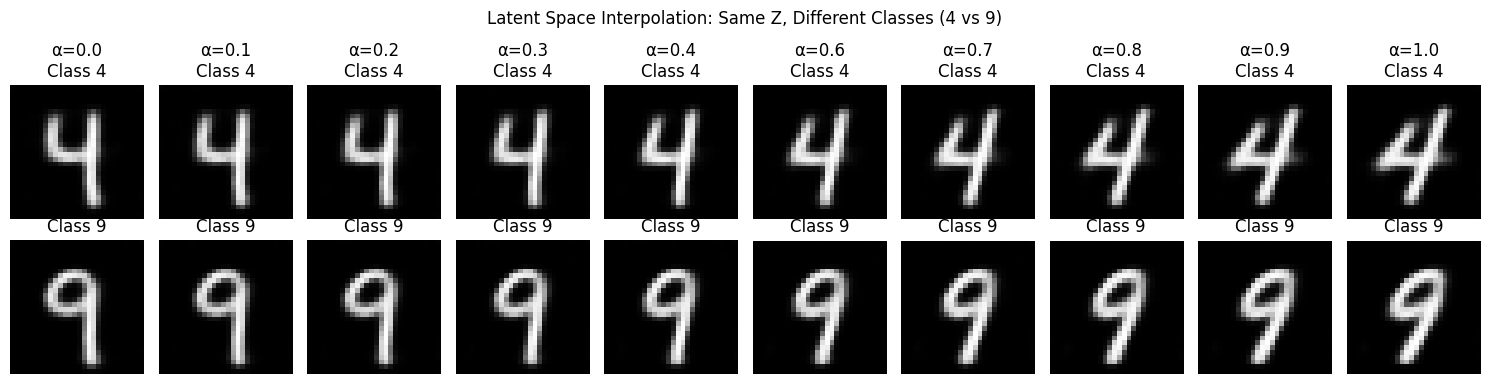

In [ ]:
def interpolate_between_digits(model, digit1, digit2, num_steps=10):
    """Interpolate between two different digit classes in latent space"""
    model.eval()

    with torch.no_grad():
        # Sample two random latent codes
        z1 = torch.randn(1, model.latent_dim).to(device)
        z2 = torch.randn(1, model.latent_dim).to(device)

        # Create interpolation steps
        alphas = torch.linspace(0, 1, num_steps).to(device)

        fig, axes = plt.subplots(2, num_steps, figsize=(15, 4))

        for i, alpha in enumerate(alphas):
            # Interpolate latent codes
            z_interp = (1 - alpha) * z1 + alpha * z2

            # Generate with digit1 class
            sample1 = model.decode(z_interp, torch.tensor([digit1]).to(device))
            img1 = (sample1.squeeze().cpu() + 1) / 2
            axes[0, i].imshow(img1, cmap='gray')
            axes[0, i].set_title(f'α={alpha:.1f}\nClass {digit1}')
            axes[0, i].axis('off')

            # Generate with digit2 class
            sample2 = model.decode(z_interp, torch.tensor([digit2]).to(device))
            img2 = (sample2.squeeze().cpu() + 1) / 2
            axes[1, i].imshow(img2, cmap='gray')
            axes[1, i].set_title(f'Class {digit2}')
            axes[1, i].axis('off')

        plt.suptitle(f'Latent Space Interpolation: Same Z, Different Classes ({digit1} vs {digit2})')
        plt.tight_layout()
        plt.show()

# Show interpolation between different digit pairs
print("Latent space interpolation examples:")
interpolate_between_digits(model, 0, 1)
interpolate_between_digits(model, 3, 8)
interpolate_between_digits(model, 4, 9)

Latent space walks:

Digit 0:


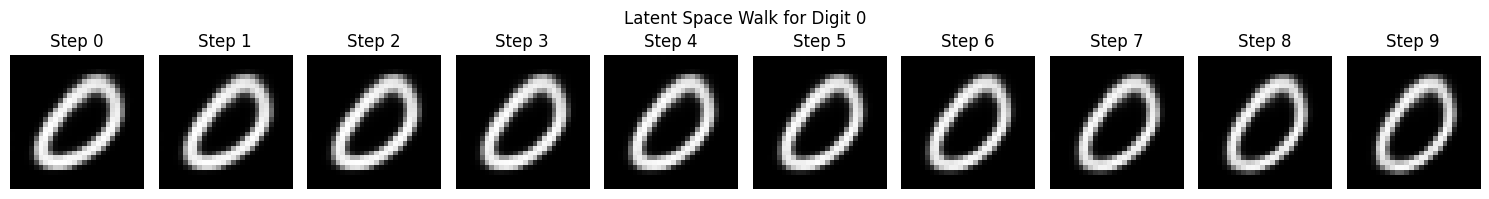


Digit 1:


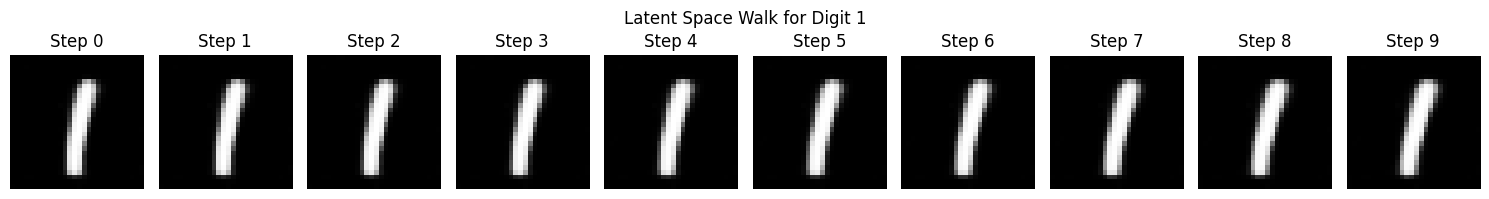


Digit 5:


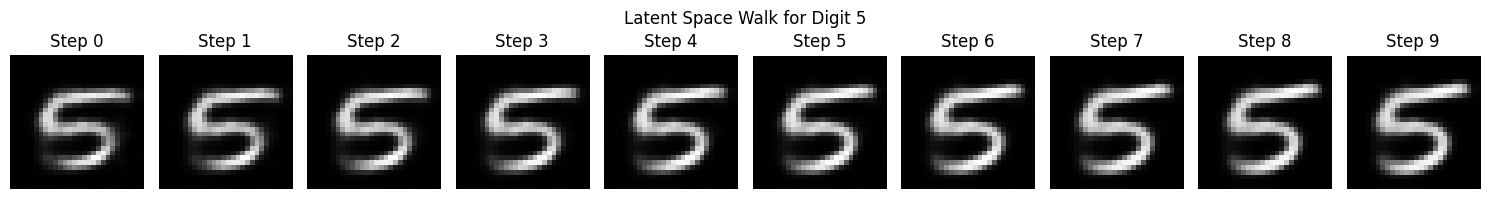


Digit 7:


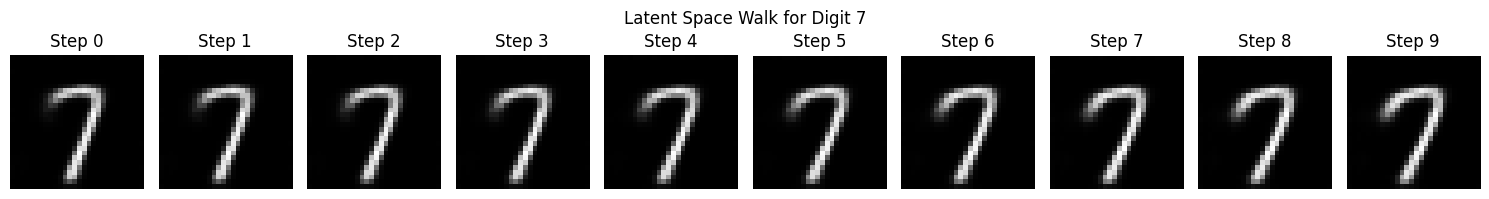

In [ ]:
def latent_walk(model, digit, num_steps=10, step_size=0.5):
    """Walk through latent space for a specific digit"""
    model.eval()

    with torch.no_grad():
        # Start with a random latent code
        z = torch.randn(1, model.latent_dim).to(device)

        # Random direction in latent space
        direction = torch.randn(1, model.latent_dim).to(device)
        direction = direction / torch.norm(direction)  # Normalize

        fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))

        for i in range(num_steps):
            # Move in the direction
            z_current = z + (i - num_steps//2) * step_size * direction

            # Generate sample
            sample = model.decode(z_current, torch.tensor([digit]).to(device))
            img = (sample.squeeze().cpu() + 1) / 2

            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'Step {i}')
            axes[i].axis('off')

        plt.suptitle(f'Latent Space Walk for Digit {digit}')
        plt.tight_layout()
        plt.show()

# Show latent walks for different digits
print("Latent space walks:")
for digit in [0, 1, 5, 7]:
    print(f"\nDigit {digit}:")
    latent_walk(model, digit)

## Model Analysis and Summary

In [ ]:
# Print final training statistics
print("=" * 60)
print("MNIST CONDITIONAL VAE TRAINING SUMMARY")
print("=" * 60)
print(f"Model Architecture:")
print(f"  - Input: 28x28x1 (MNIST grayscale images)")
print(f"  - Latent Dimension: {latent_dim}")
print(f"  - Number of Classes: {num_classes}")
print(f"  - Total Parameters: {total_params:,}")
print(f"")
print(f"Training Configuration:")
print(f"  - Epochs: {num_epochs}")
print(f"  - Batch Size: {batch_size}")
print(f"  - Learning Rate: {learning_rate}")
print(f"  - Beta (β-VAE): {beta}")
print(f"")
print(f"Final Results:")
print(f"  - Final Train Loss: {train_losses[-1]:.4f}")
print(f"  - Final Test Loss: {test_losses[-1]:.4f}")
print(f"  - Final Train Reconstruction: {train_recon_losses[-1]:.4f}")
print(f"  - Final Test Reconstruction: {test_recon_losses[-1]:.4f}")
print(f"  - Final Train KL: {train_kl_losses[-1]:.4f}")
print(f"  - Final Test KL: {test_kl_losses[-1]:.4f}")
print("=" * 60)

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'hyperparameters': {
        'latent_dim': latent_dim,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'beta': beta,
        'batch_size': batch_size
    }
}, 'mnist_cvae_model.pth')

print("Model saved as 'mnist_cvae_model.pth'")

MNIST CONDITIONAL VAE TRAINING SUMMARY
Model Architecture:
  - Input: 28x28x1 (MNIST grayscale images)
  - Latent Dimension: 64
  - Number of Classes: 10
  - Total Parameters: 2,447,553

Training Configuration:
  - Epochs: 20
  - Batch Size: 128
  - Learning Rate: 0.001
  - Beta (β-VAE): 1.0

Final Results:
  - Final Train Loss: 77.1125
  - Final Test Loss: 69.1749
  - Final Train Reconstruction: 64.9719
  - Final Test Reconstruction: 57.4051
  - Final Train KL: 12.1406
  - Final Test KL: 11.7697
Model saved as 'mnist_cvae_model.pth'
